In [ ]:
import veloxchem as vlx
import math
import numpy as np
import time
start = time.time()


In [ ]:
# Input a molecule from PubChem
molecule = vlx.Molecule.read_name('L-alanine') #L-alanine
molecule.show()

In [ ]:
# Set up the functionals and basis sets used in the calculation
opt_functional = "BLYP"
opt_basis = "def2-svp"
sp_functional = "m06-l"
sp_basis = "def2-tzvp"
tddft_functional = "cam-b3lyp"
tddft_basis = "def2-svp"

# Maximum number of optimization steps and TDDFT states
max_opt_steps = 15
number_of_tddft_states = 6

# Boltzmann settings
temp = 298.15 # Kelvin
cutoff = 0.05 # Boltzmann weight cutoff


In [ ]:
# Show available functionals and basis sets
print(vlx.available_functionals())
avail_basis_carbon = vlx.MolecularBasis.get_avail_basis('C')

print('Available basis sets for carbon:\n')

for i in range(0, len(avail_basis_carbon), 6):
    print(', '.join(avail_basis_carbon[i:i + 6]))

In [ ]:
# Generate all conformers of the molecule
conf_gen = vlx.ConformerGenerator()
conformations = conf_gen.generate(molecule)
print("Conformations generated:")
print(len(conformations['molecules']))

In [ ]:
# Show the first 5 conformers
conf_gen.show_conformers(5)


In [ ]:
# Set up the Boltzmann filter for the conformers
boltzmann_mm = []
for i in range(len(conformations['molecules'])):
    boltzmann_mm_e = conformations['energies'][i] - conformations['energies'][0]
    boltzmann_mm_p = math.exp(-boltzmann_mm_e* 1000/(8.314*temp))
    boltzmann_mm.append(boltzmann_mm_p)
boltzmann_mm = boltzmann_mm / np.sum(boltzmann_mm)

print(boltzmann_mm)

In [ ]:
# Optimize and compute single-point energies for the conformers that pass the Boltzmann filter
energies = []
geometries = []
for i in range(len(conformations['molecules'])):
    if boltzmann_mm[i] > cutoff:
        basis = vlx.MolecularBasis.read(conformations['molecules'][i], opt_basis)
        scf_drv = vlx.ScfRestrictedDriver()
        scf_drv.xcfun = opt_functional
        scf_drv.dispersion = True
        scf_drv.conv_thresh = 1e-3
        scf_drv.grid_level = 2
        #scf_drv.solvation_model = "cpcm"
        scf_drv.ri_coulomb = True
        results = scf_drv.compute(conformations['molecules'][i], basis)

        opt_drv = vlx.OptimizationDriver(scf_drv)
        opt_drv.max_iter = max_opt_steps
        opt_drv.conv_maxiter = True
        opt_results = opt_drv.compute(conformations['molecules'][i], basis, results)
        geometries.append(opt_results['final_geometry'])
        
        molecule = vlx.Molecule.read_xyz_string(opt_results['final_geometry'])
        basis = vlx.MolecularBasis.read(molecule, sp_basis)
        scf_drv = vlx.ScfRestrictedDriver()
        scf_drv.xcfun = sp_functional
        scf_drv.dispersion = True
        scf_drv.conv_thresh = 1e-3
        scf_drv.grid_level = 4
        #scf_drv.solvation_model = "cpcm"
        scf_drv.ri_coulomb = True
        results = scf_drv.compute(molecule, basis)

        energies.append(results['scf_energy'])
    else:
        continue

In [ ]:
# Set upt the Boltzmann filter for the optimized conformers
boltzmann = []
for i in range(len(energies)):
    boltzmann_e = energies[i] - min(energies)
    boltzmann_p = math.exp(-boltzmann_e* 2625.5*1000/(8.314*temp))
    boltzmann.append(boltzmann_p)
boltzmann = boltzmann / np.sum(boltzmann)
print(boltzmann)

In [ ]:
# Compute TDDFT properties for the conformers that pass the Boltzmann filter
rpa_eigenvalues = []
rpa_oscillator_strengths = []
rpa_rotatory_strengths = []

for i in range(len(boltzmann)):
    if boltzmann[i] > cutoff:
        molecule = vlx.Molecule.read_xyz_string(geometries[i])
        basis = vlx.MolecularBasis.read(molecule, tddft_basis)
        scf_drv = vlx.ScfRestrictedDriver()
        scf_drv.filename = f"rpa_results_{i+1}"

        scf_drv.xcfun = tddft_functional
        results = scf_drv.compute(molecule, basis)
        rpa_solver = vlx.LinearResponseEigenSolver()
        rpa_solver.update_settings({"nstates": number_of_tddft_states})
        rpa_solver.nto = True
        rpa_results = rpa_solver.compute(molecule, basis, results)

        rpa_eigenvalues.append(rpa_results['eigenvalues'])
        rpa_oscillator_strengths.append(rpa_results['oscillator_strengths'])
        rpa_rotatory_strengths.append(rpa_results['rotatory_strengths'])
    else:
        continue

In [ ]:
# Combine and apply the Boltzmann weights to the TDDFT results
rpa_oscillator_strengths_boltzmann = [rpa * boltz for rpa, boltz in zip(rpa_oscillator_strengths, boltzmann)]
rpa_rotatory_strengths_boltzmann = [rpa * boltz for rpa, boltz in zip(rpa_rotatory_strengths, boltzmann)]

combined_rpa = {'eigenvalues': np.concatenate(rpa_eigenvalues),
                'oscillator_strengths': np.concatenate(rpa_oscillator_strengths_boltzmann),
                'rotatory_strengths': np.concatenate(rpa_rotatory_strengths_boltzmann)}

In [ ]:
# Plot spectra for a single conformer and the combined spectra

print("Boltzmann weighted spectra of multiple conformers:")
rpa_solver.plot_uv_vis(combined_rpa)
rpa_solver.plot_ecd(combined_rpa, broadening_value=0.3)

print("Spectra of a singler conformer:")
rpa_solver.plot_uv_vis(rpa_results)
rpa_solver.plot_ecd(rpa_results, broadening_value=0.3)


In [ ]:
print("Total time:", time.time()-start)

## Computed with def2-TZVPD

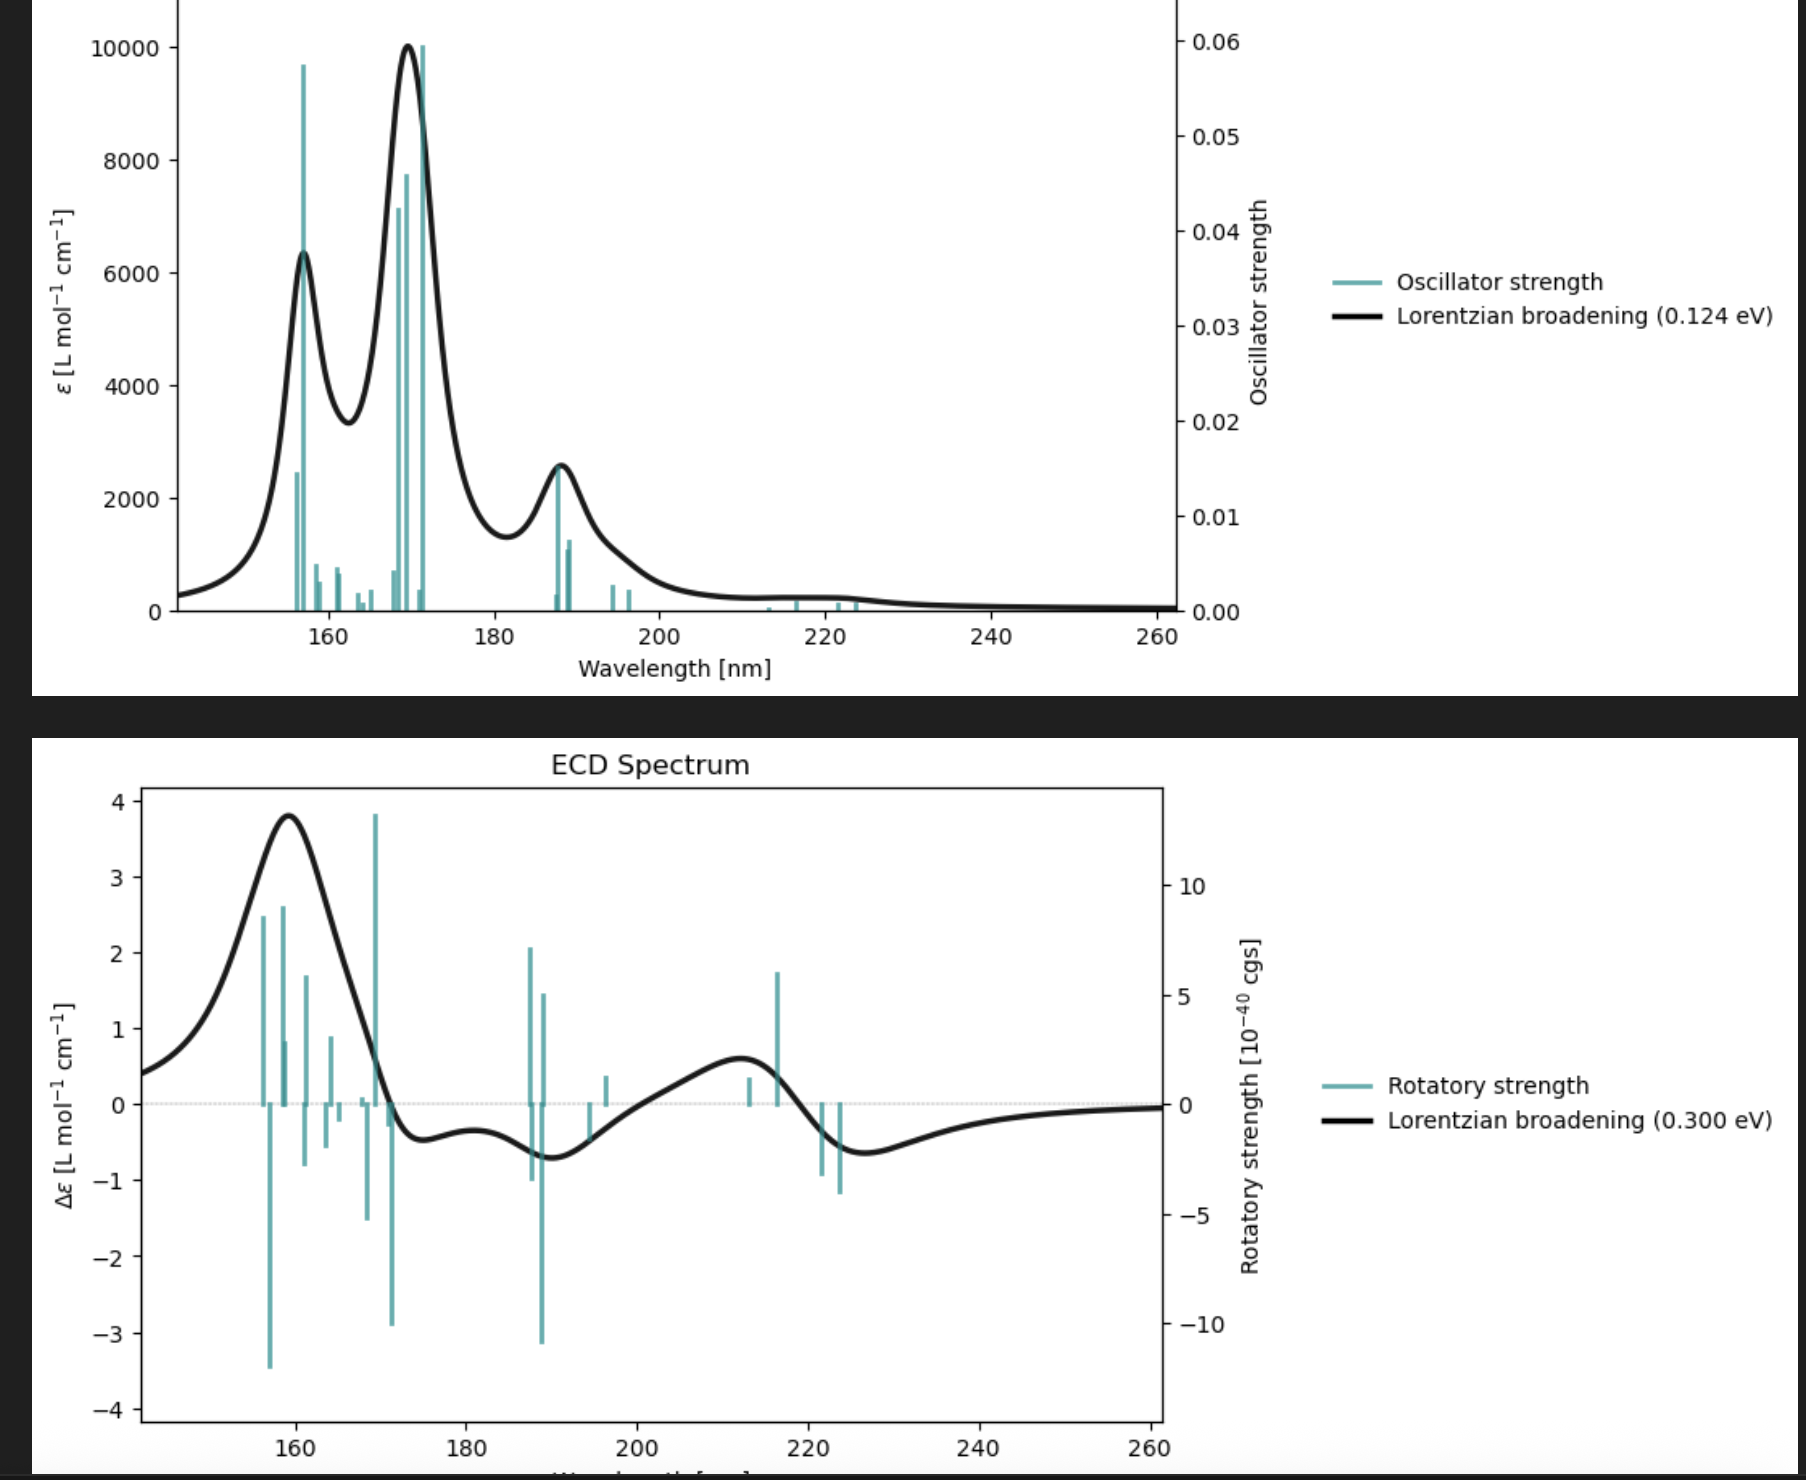

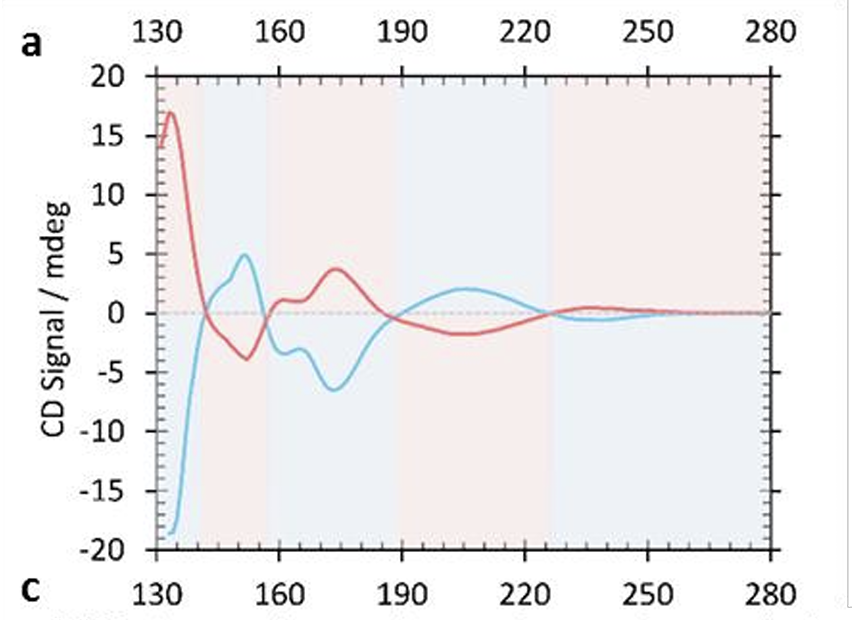

In [ ]:
viewer = vlx.OrbitalViewer()
viewer.plot(molecule, basis, scf_drv.mol_orbs)